# Combine data from Google Earth Engine (GEE) and Geoscience Australia (GA) <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[wofs_annual_summary](https://explorer.sandbox.dea.ga.gov.au/wofs_annual_summary)
[USGS Landsat 8 Surface Reflectance Tier 1](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR)

## Background
GEE is a geospatial processing service. It has the option to be run through it's online JavaScript Code Editor, or can be accessed in python platforms such as Colab and Jupyter Notebooks. GEE provides access to many different datasets, climate data, PALSAR and MODIS (https://developers.google.com/earth-engine/datasets/catalog) which can be combined with data from DEA. 

To get started with GEE these links may help:
- User guides: https://developers.google.com/earth-engine/guides
- Get started using GEE with python: https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb

## Description
This notebook demonstrates how to access data stored in GEE. For simplicity we will access Landsat. 

1. Load python packages
2. Connect to datacube
3. Connect to GEE API
4. Load GEE image
5. Convert GEE image to numpy array
6. Load GA image

***


### Load packages
Import Python packages that are used for the analysis.

In [1]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import sys
import folium
import datacube

sys.path.append("../Scripts")
from dea_plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='gee')

### Connect to the GEE API
Run `ee.Initialize` to initialize it access to thr Earth Engine servers.

In [3]:
ee.Initialize()

## Load Imagery

### Define parameters 

In [4]:
# Define parameters

# Dates
# NOTE: GEE dates are inclusive and GA are exclusive on the end date
start = '2018-01-01'
end_ga = '2018-12-31'
end_gee = '2019-01-01'

# Set the central latitude and longitude
central_lat = -35.555439 
central_lon = 138.886889

In [5]:
# Set the buffer to load around the central coordinates
buffer = 0.05 # must be small for .sampleRectangle() to work

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

### Load GEE imagery

To load imagery from GEE generally you will need to:
- define an area of interest and pass to `filterBounds`
- define a time period of interest and pass to `filterDate`
- filter on metadata (commonly cloud cover)
- select bands of interest
- reproject

Imagery without a set projection will be called in WGS 94. Landsat pixels in GEE have ar 30m in length, compared to Landsat pixels in GA.

>**Note**: All options for how to manipulate GEE objects can be found here https://developers.google.com/earth-engine/apidocs

In [6]:
# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[study_area_lon[0], study_area_lat[0]],
    [study_area_lon[0], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[0]]]], None, False)

# Filter collection to get desired image
img = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")\
        .filterBounds(aoi)\
        .filterDate(start,end_gee)\
        .filter(ee.Filter.lt('CLOUD_COVER',5))\
        .select(['B4', 'B3', 'B2'])\
        .first()\
        .reproject('EPSG:3577',None,25)\

### Convert GEE image into a numpy array

The image returned to us is an ee.Image object. To integrate this with GA imagery, we need to convert the image object into an xarray.

In [7]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = img.sampleRectangle(region=aoi)

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B2') #B2
band_arr_b5 = band_arrs.get('B3') #B3
band_arr_b6 = band_arrs.get('B4') #B4

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())

# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
np_arr_b5 = np.expand_dims(np_arr_b5, 2)
np_arr_b6 = np.expand_dims(np_arr_b6, 2)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b6, np_arr_b5, np_arr_b4), 2)

(464, 387, 3)


### Display new numpy array

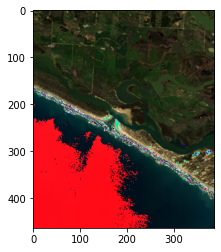

In [8]:
# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((rgb_img - 100)/3000)).astype('uint8')

plt.imshow(rgb_img_test)
plt.show()

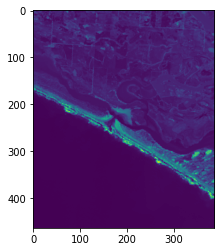

In [8]:
# Display a single band
plt.imshow(rgb_img[:,:,0])
plt.show()

### Load GA data

In [9]:
# Load wofs_annual_summary
wofs = dc.load(
              product=['wofs_annual_summary'],
              x= study_area_lon,
              y= study_area_lat,
              time=(start, end_ga),
              output_crs='EPSG:3577',
              resolution=(-25,25),
              resampling='cubic'
)

In [10]:
wofs

<xarray.Dataset>
Dimensions:      (time: 1, x: 387, y: 464)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01
  * y            (y) float64 -3.895e+06 -3.895e+06 ... -3.906e+06 -3.906e+06
  * x            (x) float64 6.185e+05 6.185e+05 ... 6.281e+05 6.281e+05
    spatial_ref  int32 3577
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 ... 13 14 14 14 14 14 15 16
    count_clear  (time, y, x) int16 20 20 20 20 20 20 19 ... 14 14 14 14 15 16
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

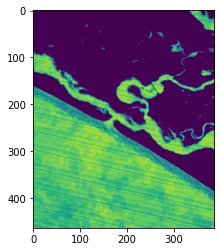

In [11]:
# Display wofs data
plt.imshow(np.array(wofs['count_wet'][0,:,:]))
plt.show()

### The imagery should now be comparable

In [ ]:
pri

Text(0.5, 1.0, 'GEE Satellite Imagery')

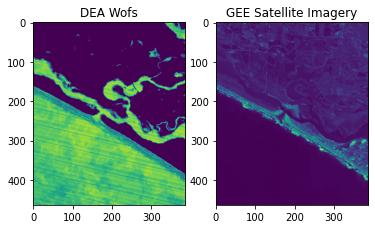

In [12]:
# Display imagery side-by-side
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.array(wofs['count_wet'][0,:,:]))
ax1.set_title('DEA Wofs')
ax2.imshow(rgb_img[:,:,0])
ax2.set_title('GEE Satellite Imagery')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)